## Create a model to predict which customer will switch to other telecom service providers

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,StratifiedKFold,GridSearchCV
from sklearn.metrics import accuracy_score,classification_report

In [2]:
df=pd.read_csv('churn_prediction.csv')
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

3 column contains object datatypes and the target variable contains boolean data types. 

In [4]:
print(len(df['State'].unique()))
print(df['International plan'].unique())
print(df['Voice mail plan'].unique())
print(df['Churn'].unique())

51
['No' 'Yes']
['Yes' 'No']
[False  True]


In [5]:
#next we convert all categorical features except State to numerical values
df.replace({'International plan':{'No':0,'Yes':1},'Voice mail plan':{'No':0,'Yes':1},'Churn':{False:0,True:1}},inplace=True)
df.head()


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [6]:
#create a new feature state_churn using feature State, it should contain the ratio of total churn in a given state and total 
# customers of a given state

state_churn= df.groupby(['State'])['Churn'].agg('mean')
state_churn.head()

State
AK    0.069767
AL    0.106061
AR    0.234043
AZ    0.066667
CA    0.208333
Name: Churn, dtype: float64

In [7]:
d=dict()
for i in df.State.unique():
    if i not in d:
        d[i]=state_churn[i]
df['state_churn']=df['State'].map(d)
df['state_churn'].head()

0    0.192308
1    0.151515
2    0.280000
3    0.151515
4    0.134615
Name: state_churn, dtype: float64

In [8]:
#create new feature 'avg_day_call_dur' using 'Total day minutes' and 'Total day calls'
#create the same for 'avg_night_call_dur' and drop the other columns(Total day minutes etc)

df['avg_day_call_dur']=df['Total day minutes']/df['Total day calls']
df['avg_night_call_dur']=df['Total night minutes']/df['Total night calls']
df['avg_eve_call_dur']=df['Total eve minutes']/df['Total eve calls']

df.drop(columns=['Total day minutes','Total day calls','Total night minutes','Total night calls','Total eve minutes','Total eve calls'],axis=1,inplace=True)



In [9]:
#apparently we have encountered some null values while feature engineering
#after checking the data we can see we got these null values when the denominator is 0. (for total day calls, total night calls, total eve calls)
#so we can just replace them with 0 or drop the whole row.
df[df.isna().any(axis=1)]

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,state_churn,avg_day_call_dur,avg_night_call_dur,avg_eve_call_dur
1057,SD,98,415,0,0,0,0.00,13.57,7.52,6.8,1,1.84,4,1,0.122449,NaN,1.898864,1.227692
1100,VT,101,510,0,0,0,0.00,16.33,7.60,7.2,4,1.94,1,0,0.105263,NaN,1.776842,1.614286
2358,UT,97,415,0,0,0,35.56,0.00,7.89,11.8,6,3.19,1,0,0.133333,1.561194,1.865957,NaN


In [10]:
df=df.fillna(0)
df.isna().sum()

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day charge          0
Total eve charge          0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
state_churn               0
avg_day_call_dur          0
avg_night_call_dur        0
avg_eve_call_dur          0
dtype: int64

<AxesSubplot:>

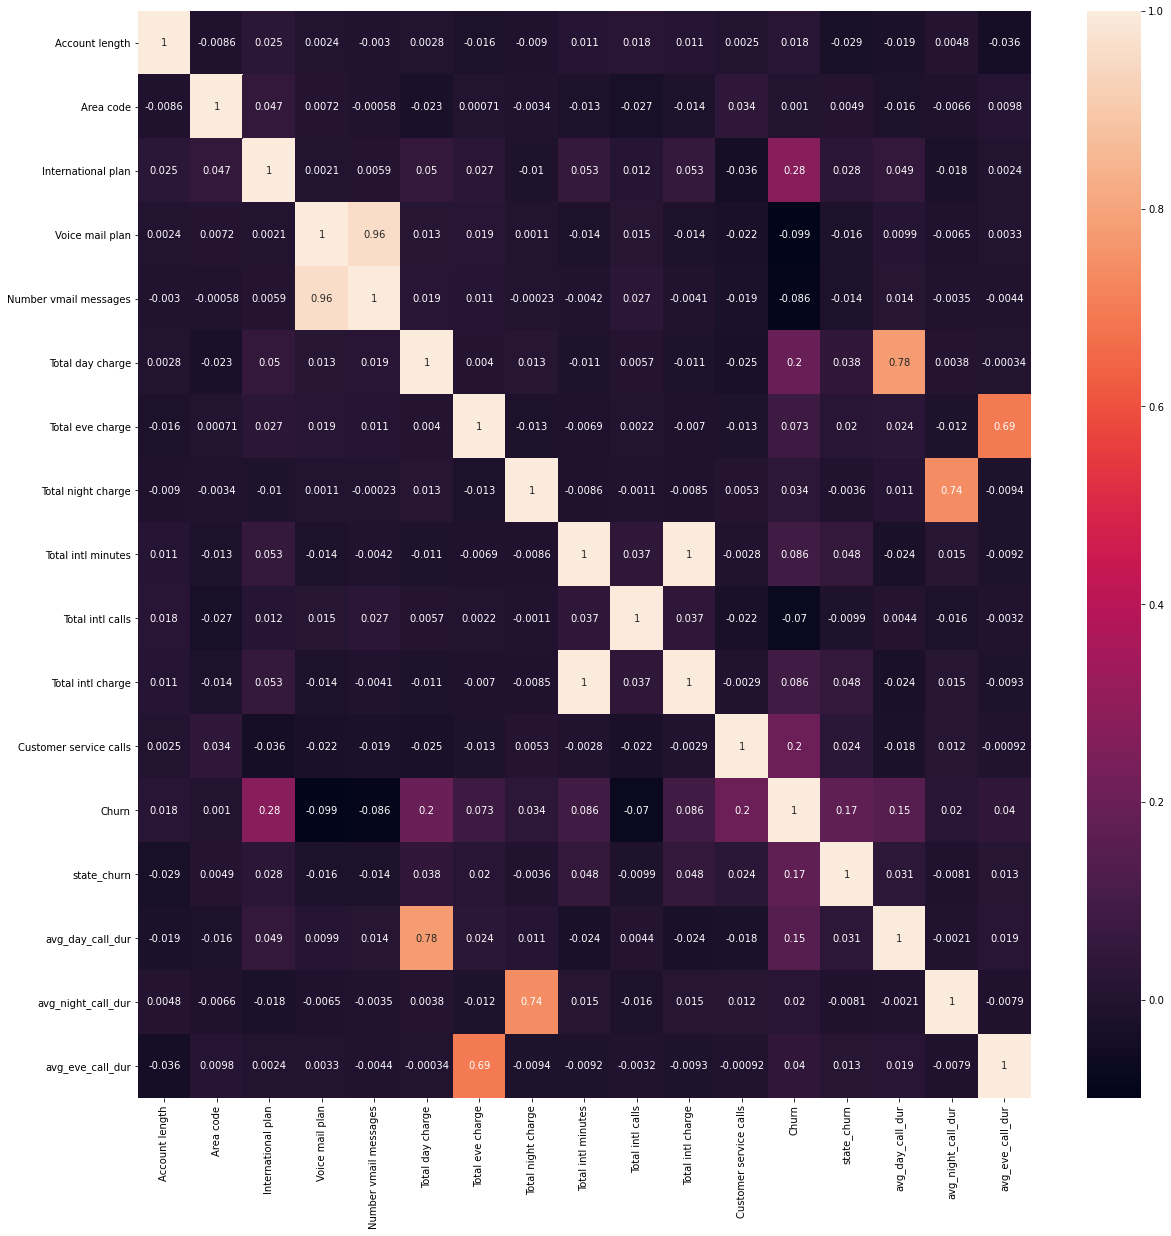

In [11]:
#we plot the correlation 

fig,ax= plt.subplots(figsize=(20,20))
cor=df.corr()
sns.heatmap(cor,annot=True,ax=ax)

In [13]:
#we drop state as we cannot use object for prediction
#split the dataset for training and validation

x=df.drop(columns=['State','Churn'],axis=1)
y=df['Churn']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=111)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1999, 16)
(667, 16)
(1999,)
(667,)


In [15]:
#perform stratified K-Fold cross validation
#calculate the mean score of each iteration

cv=StratifiedKFold(10)
model_rf=RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=7)

model_dt=DecisionTreeClassifier()

score_rf=cross_val_score(model_rf, x_train,y_train,cv=cv)
print(f'Score of random forest classifier: {score_rf.mean()}')

score_dt=cross_val_score(model_dt,x_train,y_train,cv=cv)
print(f'Score of Decision Tree Classifier: {score_dt.mean()}')


Score of random forest classifier: 0.9459648241206029
Score of Decision Tree Classifier: 0.9099723618090453


Since We are getting higher accuracy from Random Forest Classifier let us train our model with that

In [17]:
#perform Grid Search cv on RFC to find the best number of trees between 20 and 100
#max depth for the trees, between 3 and 15
#maximum features to be used, between range 4 and 17

model_params = {'n_estimators':range(20,100,20),'max_depth':range(3,15),'max_features':range(4,17)}
model_cv = GridSearchCV(model_rf,model_params,cv=5,n_jobs=-1,verbose=True,return_train_score=True,scoring='recall')
model_cv.fit(x_train,y_train)

Fitting 5 folds for each of 624 candidates, totalling 3120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=7),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 15),
                         'max_features': range(4, 17),
                         'n_estimators': range(20, 100, 20)},
             return_train_score=True, scoring='recall', verbose=True)

In [18]:
model_cv.best_params_

{'max_depth': 10, 'max_features': 15, 'n_estimators': 40}

In [19]:
model_cv.best_score_

0.7085953878406708

In [20]:
model_cv.best_estimator_

RandomForestClassifier(max_depth=10, max_features=15, n_estimators=40,
                       n_jobs=-1, random_state=7)

In [21]:
#train the random forest model

final_model= model_cv.best_estimator_

final_model.fit(x_train,y_train)
y_pred=final_model.predict(x_test)

In [23]:
#evaluate the model
print(f"Accuracy score on test data is {accuracy_score(y_test,y_pred)}")

print('classification report: \n',classification_report(y_test,y_pred))


Accuracy score on test data is 0.9310344827586207
classification report: 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       547
           1       0.89      0.71      0.79       120

    accuracy                           0.93       667
   macro avg       0.91      0.84      0.87       667
weighted avg       0.93      0.93      0.93       667

